In [14]:
!pip install torchstain

In [15]:

import os
import cv2
import time
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from sklearn import metrics as mc
# import torchstain

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "/kaggle/input/crc-tissue-phenotyping-crc-tp-dataset/Fold1/"
DIR_TEST = "/kaggle/input/nct-crc-he-100k-nonorm/NCT-CRC-HE-100K-NONORM/"


In [16]:
import torchstain
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
target = cv2.imread('/kaggle/input/crc-tissue-phenotyping-crc-tp-dataset/Fold1/Training/Tumor/1000.png')
target = cv2.resize(target, (128, 128))
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
target = np.transpose(target, (2, 0, 1))
target= torch.tensor(target)
normalizer.fit(target)

In [17]:
def get_instance_count():
    ## Displaying instance Count for each class
    path = os.path.join(DIR_TRAIN, 'Training')
    
    print("Instances Count: ")
    for file in os.listdir(path):
        print(file, len(os.listdir(os.path.join(path, file))))
    print('\n\n')


def get_df_and_class_mapping(path):
    labels_mapping = dict()
    file_path = []
    class_label = []
    
    for index,classname in enumerate(os.listdir(path)): 
        labels_mapping[classname] = index
        for filename in os.listdir(os.path.join(path, classname)):
            file_path.append(os.path.join(path, classname, filename))
            class_label.append(index)
    
    file = {"img": file_path, "class": class_label}
    df = pd.DataFrame(file)
    
    return df, labels_mapping
    

def get_test_df_and_class_mapping(path):
    labels = {'STR': 'Stroma', 'TUM': 'Tumor', 'MUS': 'Muscle', 'DEB': 'Debris', 'NORM': 'Benign', 'LYM': 'Inflammatory'}
    mapping = {'Complex Stroma': 0,
         'Stroma': 1,
         'Tumor': 2,
         'Inflammatory': 3,
         'Benign': 4,
         'Muscle': 5,
         'Debris': 6}
    
    labels_mapping = dict()
    file_path = []
    class_label = []
    
       
    
    for _,classname in enumerate(os.listdir(path)): 
        if not classname in labels.keys():
            continue
            
        index = mapping[labels[classname]]
        labels_mapping[labels[classname]] = index
        for filename in os.listdir(os.path.join(path, classname)):
            file_path.append(os.path.join(path, classname, filename))
            class_label.append(index)
    
    file = {"img": file_path, "class": class_label}
    df = pd.DataFrame(file)
    
    return df, labels_mapping


    
    
        
        
    
    
    
    
    
        


In [18]:
## Formulating Datasets and label mapping

path = DIR_TEST
test_df , test_labels_mapping = get_test_df_and_class_mapping(path)


    
    

In [19]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2


def get_transform_valid():
    return A.Compose([
       
        A.Resize(128, 128),
        ToTensorV2(),
        
    ])

class BCIDataset(Dataset):
    
    def __init__(self, base_path, images, labels, transforms = None):
        
        super().__init__()
        self.base_path = base_path
        self.images = images
        self.labels = labels
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.base_path + self.images[index]
        
        #Reading image
        image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        
        
        
        if self.transforms:
            image= self.transforms(image=image)["image"]
        
        try:
            image, H, E = normalizer.normalize(I=image, stains=True)
            image = torch.tensor(np.transpose(image, (2, 0, 1)))
        except:
            pass

        
        
        image = image.float()
        image = image / 255.0
        label = self.labels[index] - 1
        label = torch.tensor(label)
        
        #Applying transforms on image
        
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.images)


In [20]:

valid_dataset = BCIDataset("",test_df["img"].to_list(), test_df["class"].to_list(), get_transform_valid())


valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 512,
    shuffle=False,
    num_workers = 4,
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
# for images, labels in train_data_loader:
#     print(labels)
#     fig, ax = plt.subplots(figsize = (10, 10))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.imshow(make_grid(images, 4).permute(1,2,0))
#     break

In [22]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

Loaded pretrained weights for efficientnet-b0


In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [24]:

torch.cuda.empty_cache()
softmax = torch.nn.functional.softmax


# model.to(device)
model = nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(torch.load("/kaggle/input/ms-deep-learning-a1/model_0.9012__0.8849.pth"))

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss().to(device)

In [25]:
### Training Code
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

for epoch in range(1):
    
    print("epoch: ", epoch)
    
    start = time.time()

    
    
    valid_labels = []
    valid_preds = []
    val_epoch_loss = []
    

    #Validation
    model.eval()
    with torch.no_grad():
        print("Test Set")
        for images, labels in tqdm(valid_data_loader):
        
            images = images.to(device)
            labels = labels.to(device)
        
            #Forward ->
            preds = model(images)
            preds1 = torch.argmax(softmax(preds.clone(), dim=1), dim=1)
        
            #Calculate Accuracy
            valid_labels += labels.detach().cpu().numpy().tolist()
            valid_preds += preds1.detach().cpu().numpy().tolist()
            

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
    
    
    
    
    

epoch:  0
Test Set


  0%|          | 0/137 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

** Epoch 0 ** - Epoch Time 405
Val Loss = 1.2891
Val F1_Score = 0.6413882944485091 % 

Valid Confusion Matrix: 


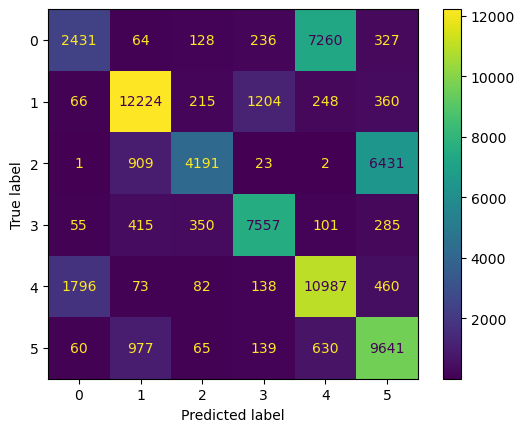

In [26]:
 valid_precision, valid_recall, valid_f1_score, _ = precision_recall_fscore_support(valid_labels, valid_preds, average='macro')

end = time.time()


#Print Epoch Statistics
print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))

print("Val Loss = {}".format(round(np.mean(val_epoch_loss), 4)))
print("Val F1_Score = {} % \n".format(valid_f1_score))




valid_cf = mc.confusion_matrix(valid_labels, valid_preds)



print("Valid Confusion Matrix: ",)
pt = mc.ConfusionMatrixDisplay(confusion_matrix=valid_cf, display_labels=[0,1,2,3,4,5])
pt.plot()

plt.show()
